In [1]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

import keras
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import to_categorical

In [2]:
import crystal
import numpy as np

In [3]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range [-1, +1]
    train_norm = (train_norm / 255.0 - 0.5) * 2.0
    test_norm = (test_norm / 255.0 - 0.5) * 2.0
    # return normalized images
    return train_norm, test_norm

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    figure(figsize=(8,8))
    # plot loss
    pyplot.subplot(211)
    pyplot.title("Cross Entropy Loss")
    pyplot.plot(history.history["loss"], color="blue", label="train")
    pyplot.plot(history.history["val_loss"], color="orange", label="test")
    pyplot.legend(["train", "test"])
    # plot accuracy
    pyplot.subplot(122)
    pyplot.title("Classification Accuracy")
    pyplot.plot(history.history["accuracy"], color="blue", label="train")
    pyplot.plot(history.history["val_accuracy"], color="orange", label="test")
    pyplot.legend(["train", "test"])
    pyplot.draw()

In [5]:
# define model
def define_model(
        initializer=None, 
        regularizer=None, 
        noise_std=0.0, 
        dropout_rate=0.0,
        negative_slope=0.0,
        layers=[256]):
    # ---
    input_layer = keras.Input(shape=(28, 28, 1), name="input")
    x = keras.layers.Flatten()(input_layer)
    if noise_std > 0.0:
        x = keras.layers.GaussianNoise(noise_std)(x)
    for layer in layers:
        x = keras.layers.Dense(layer, 
                               use_bias=True,
                               activation="linear",
                               kernel_regularizer=regularizer,
                               kernel_initializer=initializer)(x)
        x = keras.layers.ReLU(negative_slope=negative_slope)(x)
        if dropout_rate > 0.0:
            x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(10, 
                           use_bias=False,
                           activation="linear", 
                           kernel_regularizer=regularizer,
                           kernel_initializer=initializer)(x)
    result = keras.layers.Softmax()(x)
    model = keras.Model(inputs=input_layer, 
                        outputs=result, 
                        name="model_base")
    # compile model
    opt = keras.optimizers.SGD(lr=0.001, 
                               momentum=0.9)
    model.compile(optimizer=opt, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [6]:
# run the test harness for evaluating a model
def run_test_harness(model, epochs=100):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # fit model
    history = model.fit(
        x=trainX, 
        y=trainY, 
        epochs=epochs, 
        batch_size=128, 
        validation_data=(testX, testY), 
        verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print("accuracy: %.3f" % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [7]:
# Initialise to set kernel to required value
def kernel_init(shape, dtype):
    kernel = np.zeros(shape)
    max_dim = max(shape[0],shape[1])
    simplex_matrix = crystal.create_simplex_matrix(dimensions=max_dim, distance=1.0)
    #simplex_matrix = np.transpose(simplex_matrix)
    kernel[:, :] = simplex_matrix[0:shape[0], 0:shape[1]]
    return kernel

## Set test variables

In [8]:
epochs = 50
noise_std = 0.0
dropout_rate = 0.0
negative_slope = 1
layers = [256]

## Glorot / Xavier Initializer

accuracy: 92.590


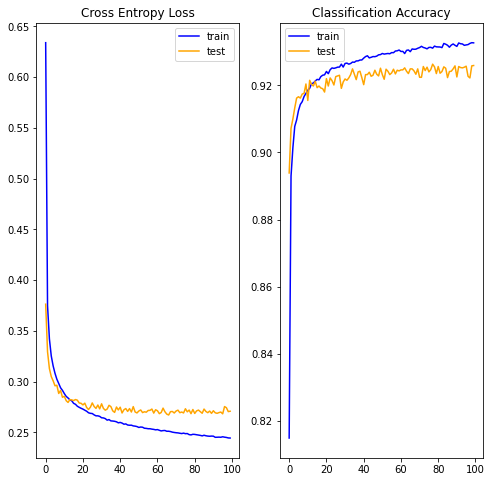

In [9]:
model = define_model(
            initializer=keras.initializers.GlorotNormal(), 
            regularizer=None,
            dropout_rate=dropout_rate,
            negative_slope=negative_slope,
            layers=layers)
run_test_harness(model, epochs=epochs)

## Crystal / Simplex Initializer

accuracy: 92.490


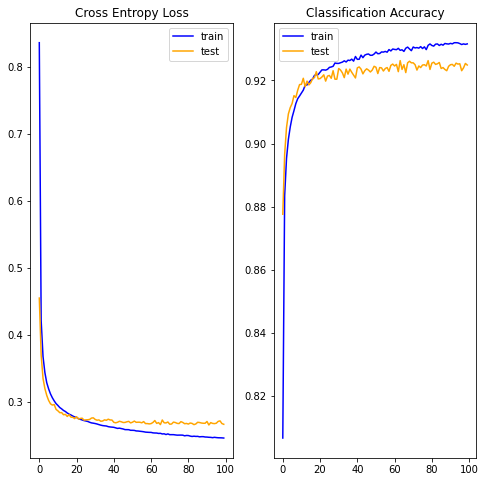

In [10]:
model = define_model(
            initializer=kernel_init, 
            regularizer=None, 
            dropout_rate=dropout_rate,
            negative_slope=negative_slope,
            layers=layers)
run_test_harness(model, epochs=epochs)